# Sub-fase 4.3: Artefactos de Resultados (ULTRA)

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from scipy.stats import mannwhitneyu

# Style and Seed
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Paths
FIGURES_DIR = "phase4_figures"
TABLES_DIR = "phase4_tables"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

# Inputs
PHASE3_CSV = "../../data/phase3/phase3_results.csv"
PHASE2_OCCURRENCES = "../../data/phase2/embeddings_occurrences.csv" # If exists
DIMENSIONS_JSON = "../../data/dimensiones_ancla.json"

print("Setup Complete. SEED=42.")


Setup Complete. SEED=42.


In [2]:

# Load Data
try:
    df = pd.read_csv(PHASE3_CSV)
    df['window_end_month'] = pd.to_datetime(df['window_end_month'])
    df.sort_values('window_end_month', inplace=True)
    df.set_index('window_end_month', inplace=True)
    print(f"Loaded Phase 3 Results: {len(df)} rows")
except Exception as e:
    print(f"CRITICAL FAIL: Could not load {PHASE3_CSV}")
    raise e

# Helpers
variants = ["baseline"]
if any("dapt" in c for c in df.columns):
    variants.append("dapt")
strategies = ["penultimate", "last4_concat"]
dims = ["funcional", "social", "afectiva"]

print(f"Variants: {variants}")
print(f"Strategies: {strategies}")


Loaded Phase 3 Results: 42 rows
Variants: ['baseline', 'dapt']
Strategies: ['penultimate', 'last4_concat']


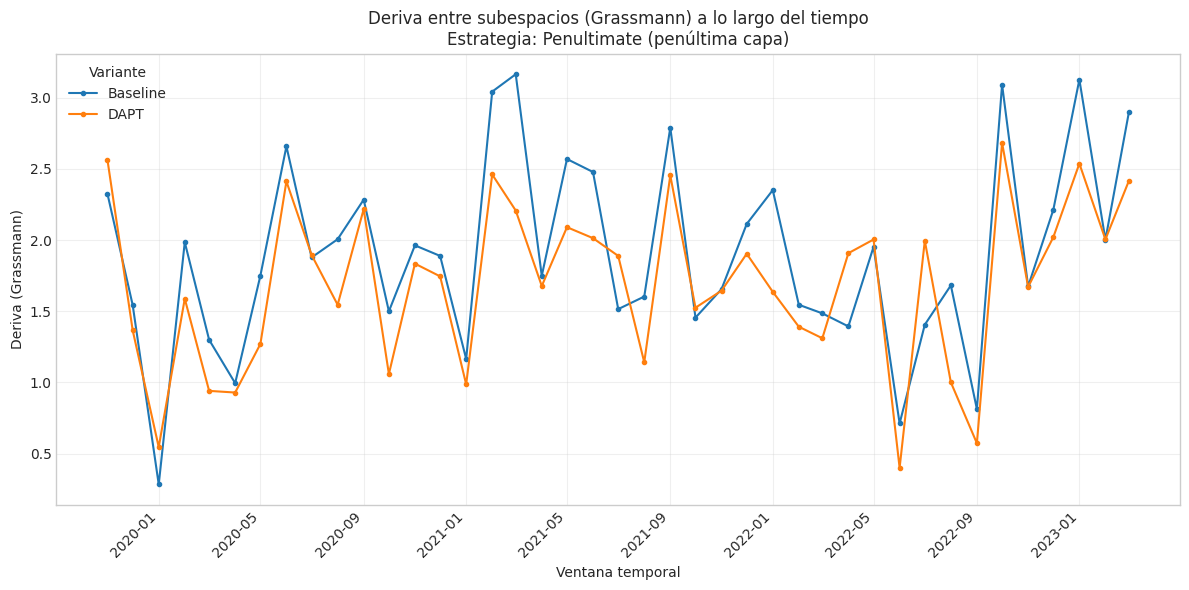

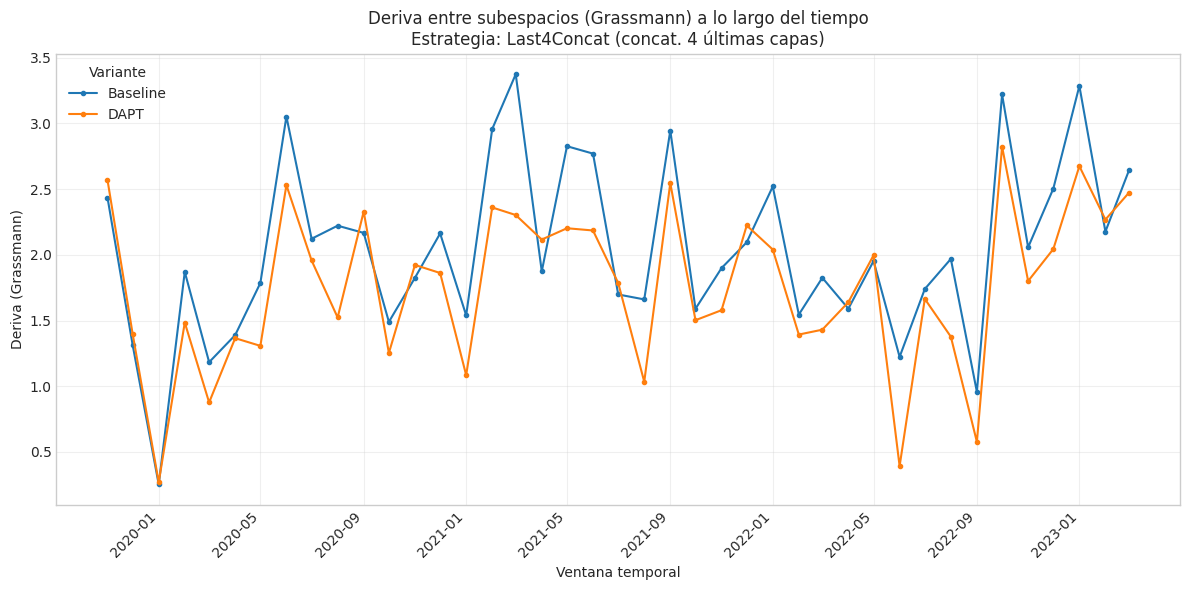

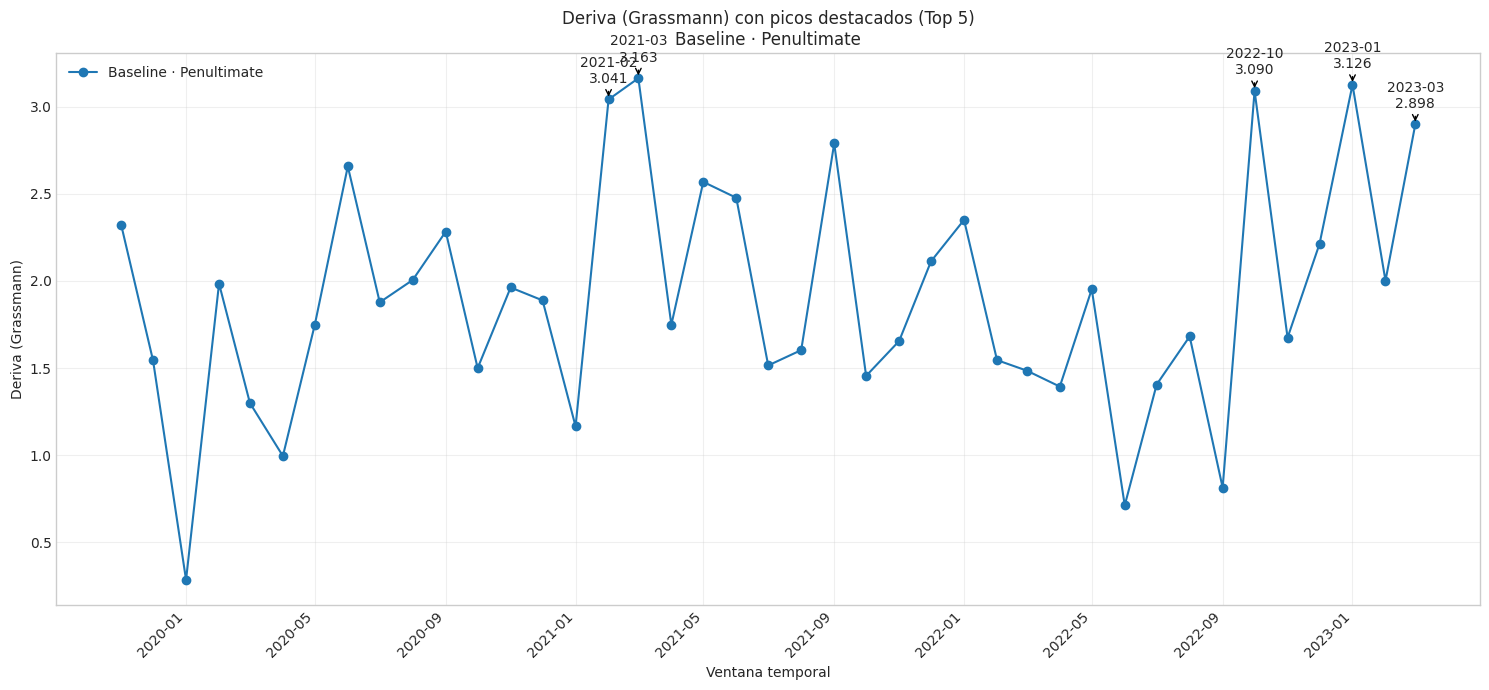

Exported rankings.


In [5]:
# --- 1. Drift & Timelines (Narrativa Visual) ---

import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'  # evita problemas de glifos raros

# Etiquetas solo para visualización (no afectan a columnas/archivos)
variant_label_es = {
    "baseline": "Baseline",
    "dapt": "DAPT"
}
strategy_label_es = {
    "penultimate": "Penultimate (penúltima capa)",
    "last4_concat": "Last4Concat (concat. 4 últimas capas)"
}

# A. Deriva por estrategia y variante
for s in strategies:
    plt.figure(figsize=(12, 6))

    for v in variants:
        col = f"drift_{v}_{s}"
        if col in df.columns:
            v_lbl = variant_label_es.get(v, v)
            plt.plot(df.index, df[col], label=v_lbl, marker='.')

    s_lbl = strategy_label_es.get(s, s)
    plt.title(f"Deriva entre subespacios (Grassmann) a lo largo del tiempo\nEstrategia: {s_lbl}")
    plt.xlabel("Ventana temporal")
    plt.ylabel("Deriva (Grassmann)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Variante", frameon=False)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/43_drift_timeline_{s}.png")
    plt.show()

# B. Deriva anotada (Baseline + Penultimate)
target_col = "drift_baseline_penultimate"
if target_col in df.columns:
    top_5 = df[target_col].nlargest(5)

    plt.figure(figsize=(15, 7))
    plt.plot(
        df.index, df[target_col],
        label="Baseline · Penultimate",
        marker='o', color='tab:blue'
    )

    # Anotar picos (Top 5) con fecha y valor
    for date, val in top_5.items():
        plt.annotate(
            f"{date.strftime('%Y-%m')}\n{val:.3f}",
            (date, val),
            xytext=(0, 12),
            textcoords='offset points',
            ha='center',
            arrowprops=dict(arrowstyle="->")
        )

    plt.title("Deriva (Grassmann) con picos destacados (Top 5)\nBaseline · Penultimate")
    plt.xlabel("Ventana temporal")
    plt.ylabel("Deriva (Grassmann)")
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=False)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/43_drift_timeline_annotated.png")
    plt.show()

# C. Tabla de rankings (sin cambios, no es gráfico)
rankings_list = []
for v in variants:
    for s in strategies:
        col = f"drift_{v}_{s}"
        if col in df.columns:
            # Top Drift
            top_d = df[col].nlargest(5)
            for d, val in top_d.items():
                rankings_list.append({
                    "metric": "drift", "variant": v, "strategy": s,
                    "window": d, "value": val, "type": "absolute"
                })

            # Top Delta Drift
            delta = df[col].diff().abs()
            top_delt = delta.nlargest(5)
            for d, val in top_delt.items():
                rankings_list.append({
                    "metric": "drift", "variant": v, "strategy": s,
                    "window": d, "value": val, "type": "delta"
                })

pd.DataFrame(rankings_list).to_csv(f"{TABLES_DIR}/43_key_windows_rankings.csv")
print("Exported rankings.")



=== GENERANDO HEATMAPS DE ALINEACIÓN DE SUBESPACIOS ===


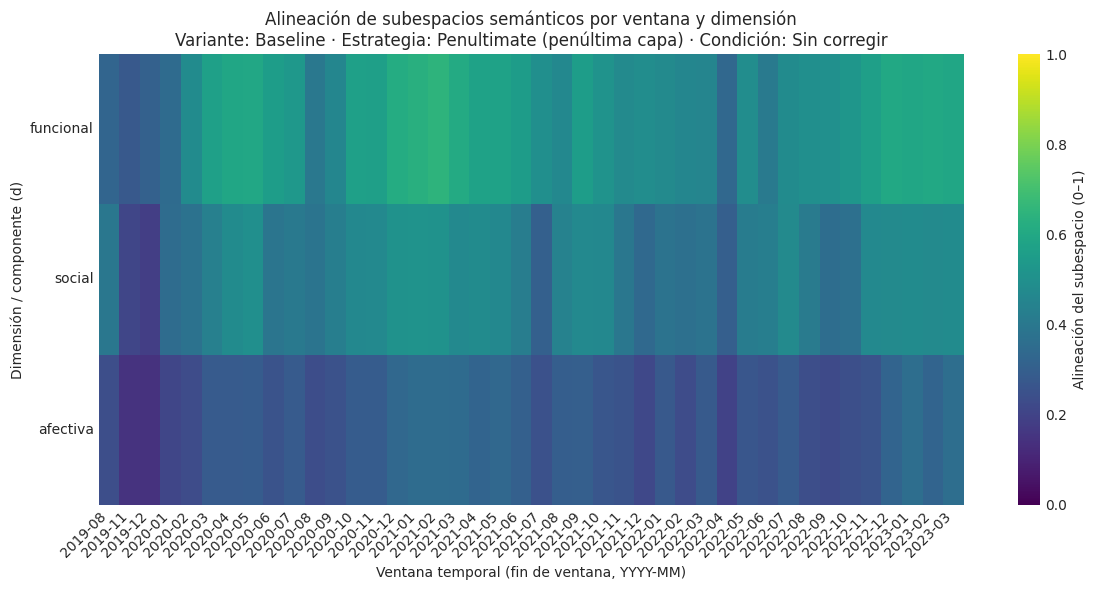

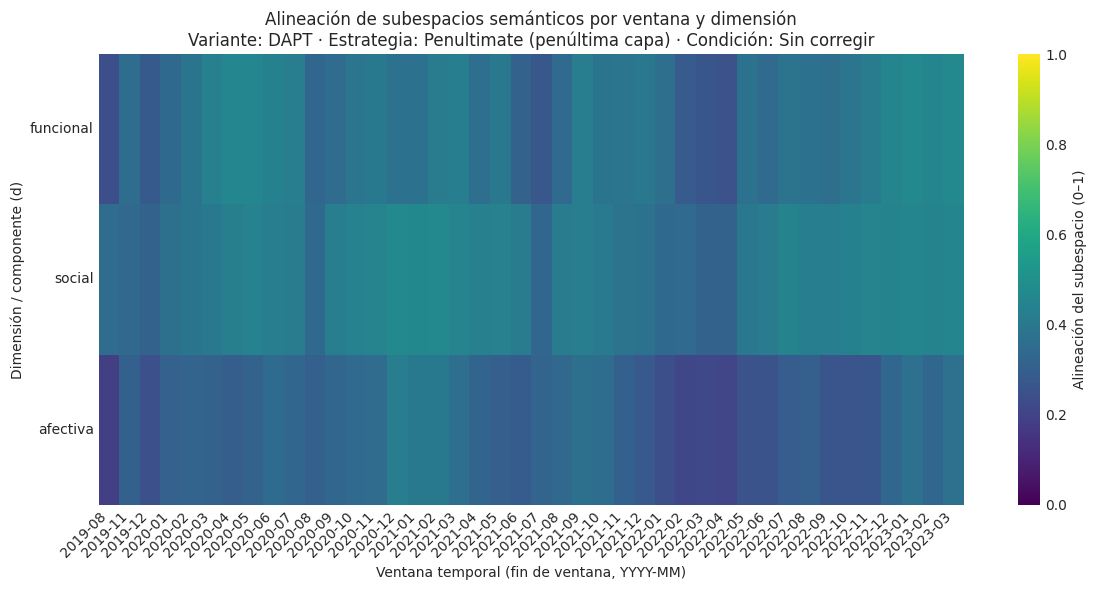

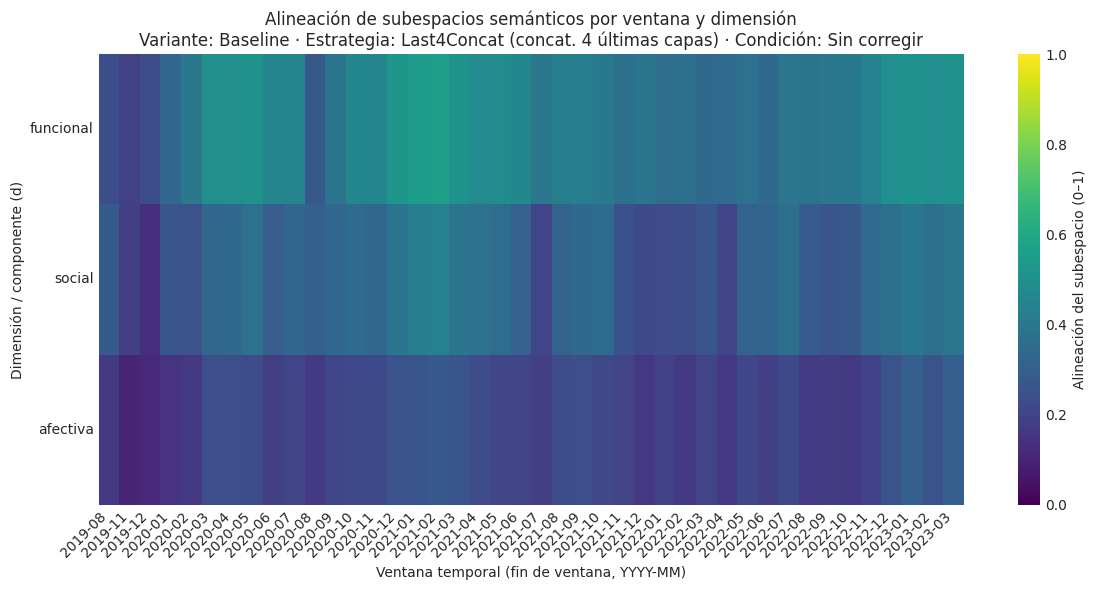

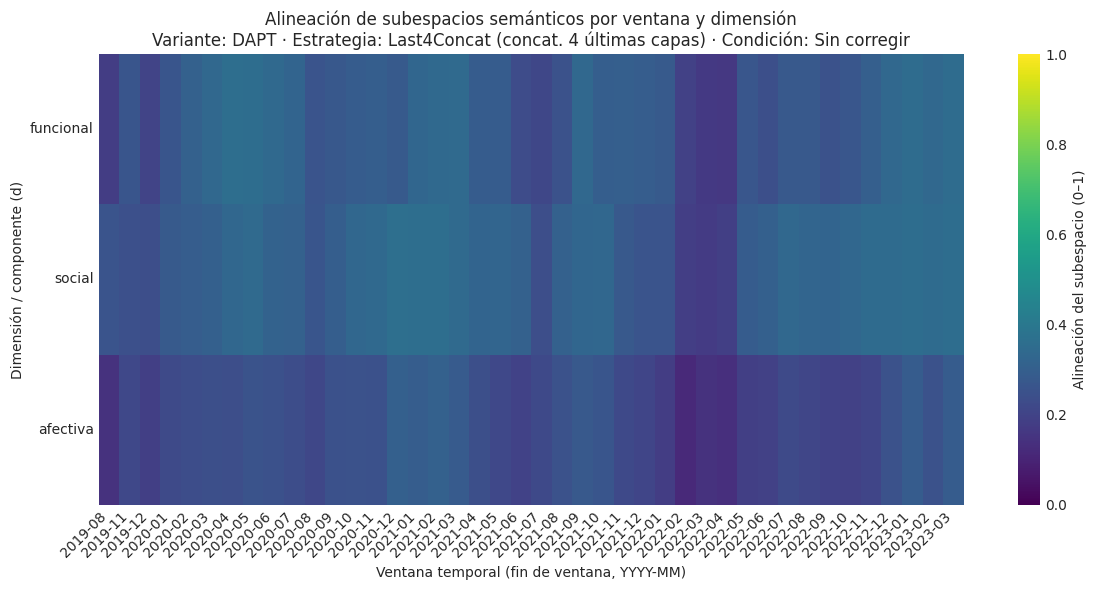

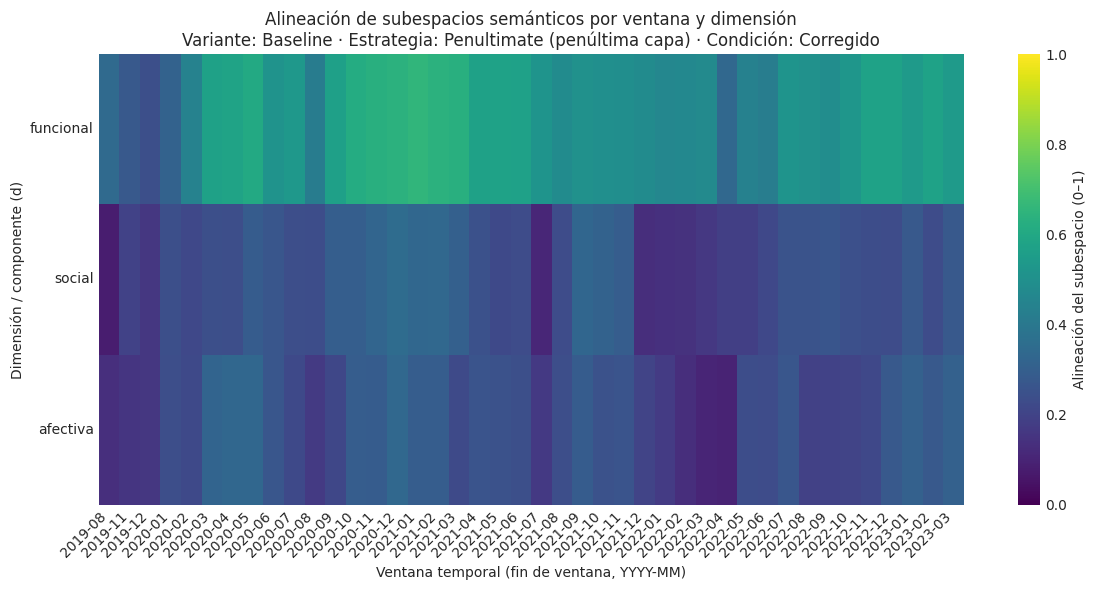

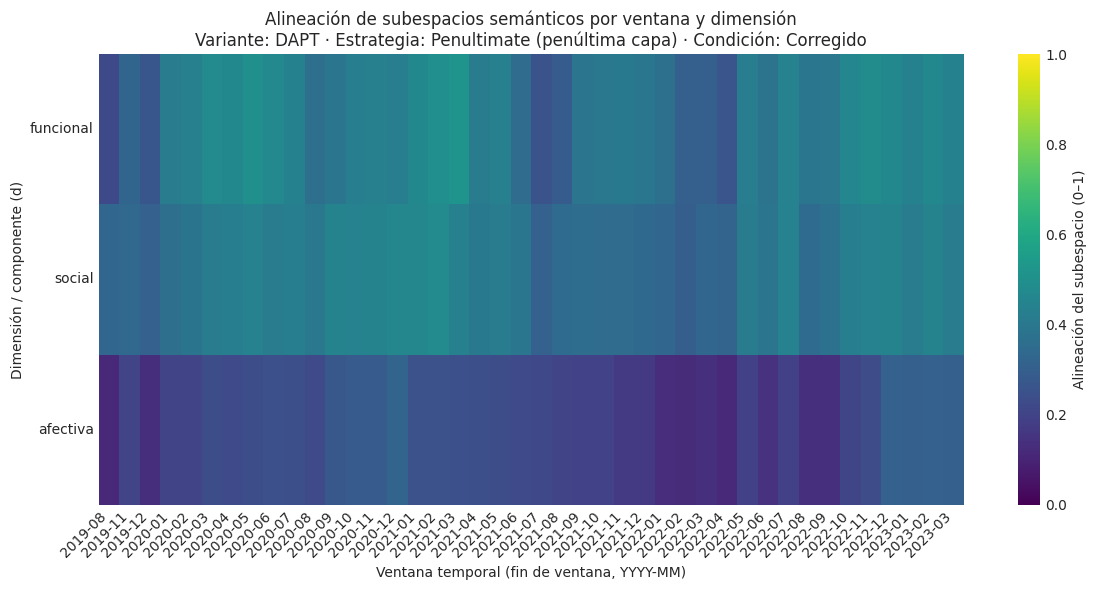

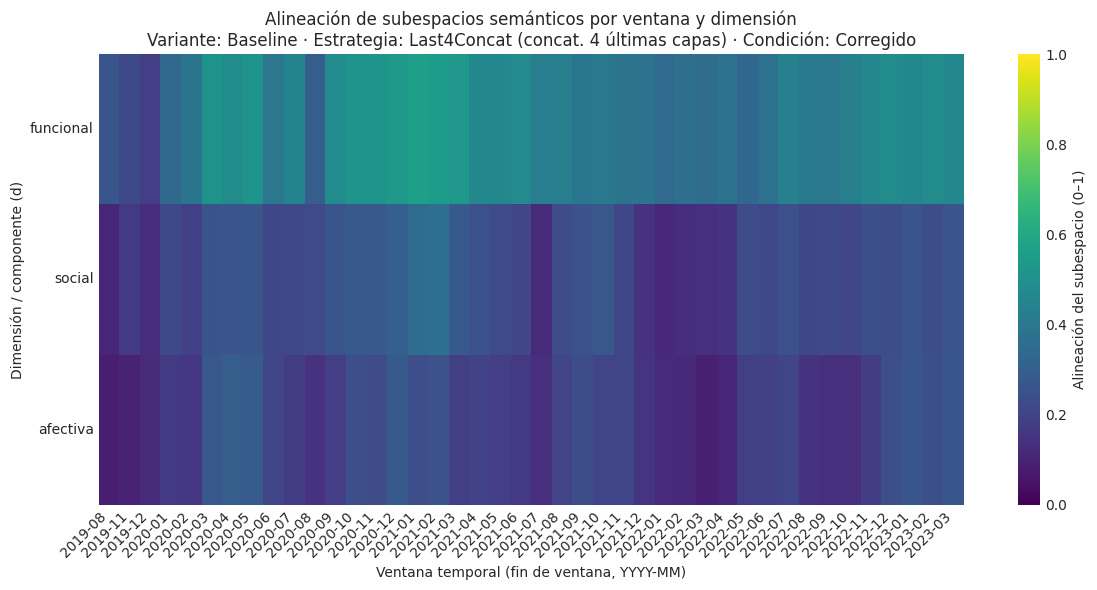

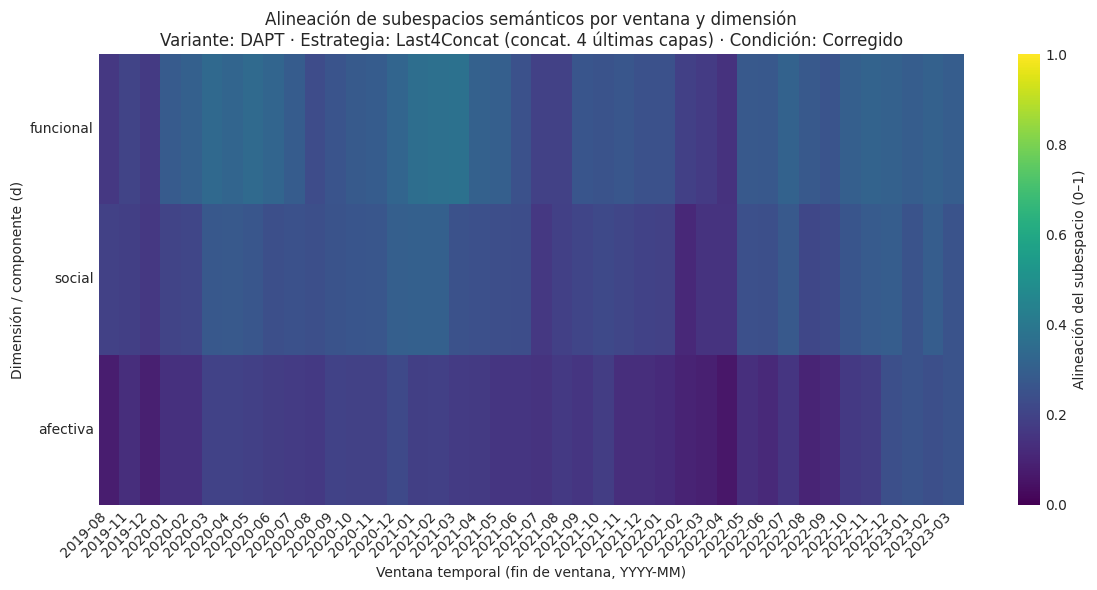


=== GENERANDO HEATMAPS DE PROYECCIÓN DEL CENTROIDE ===


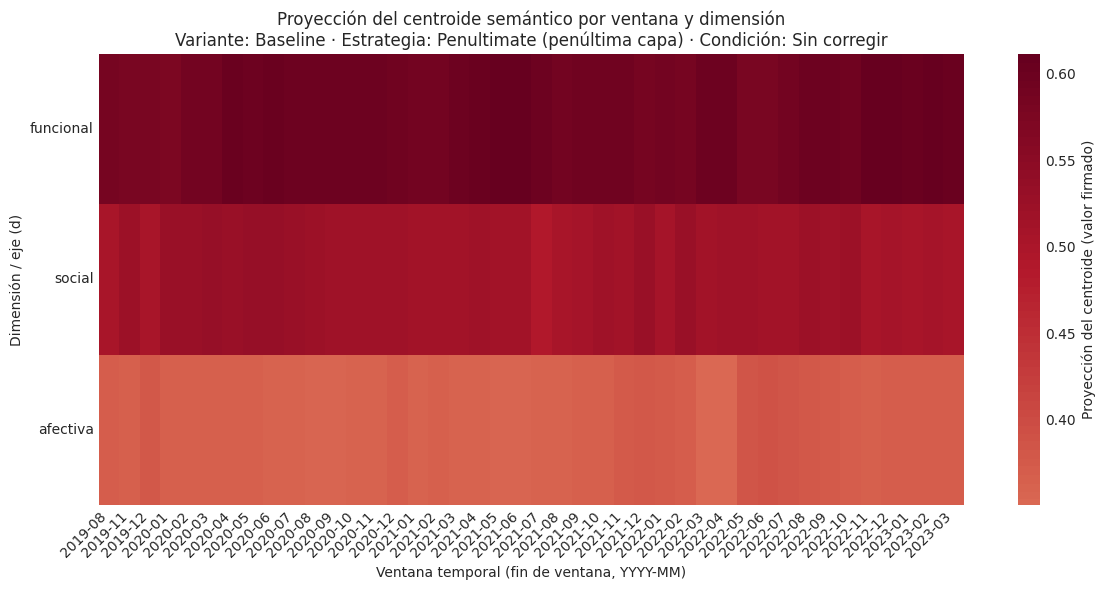

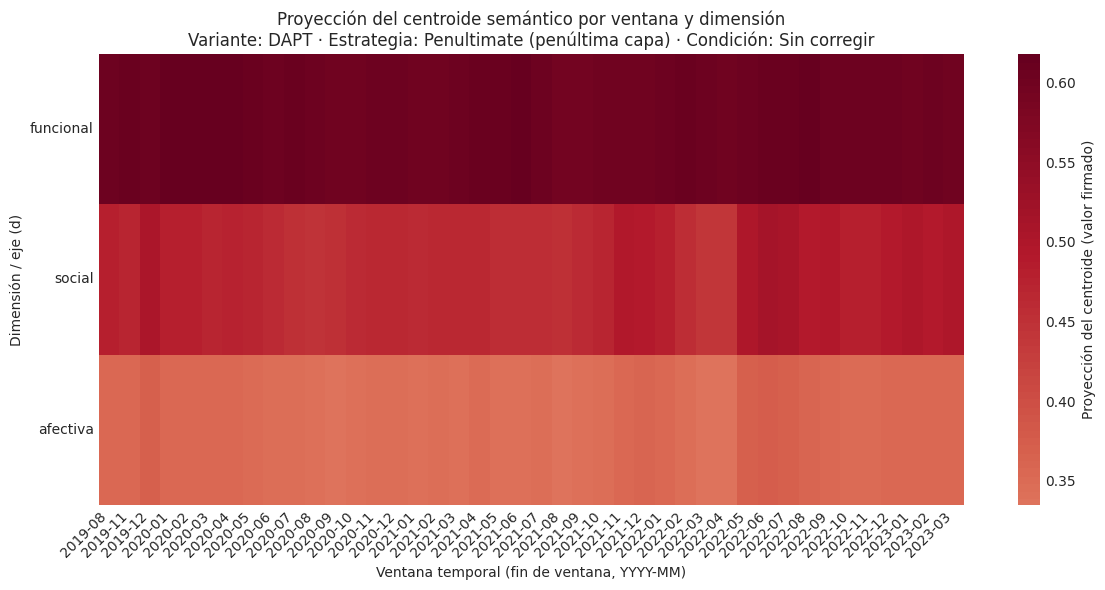

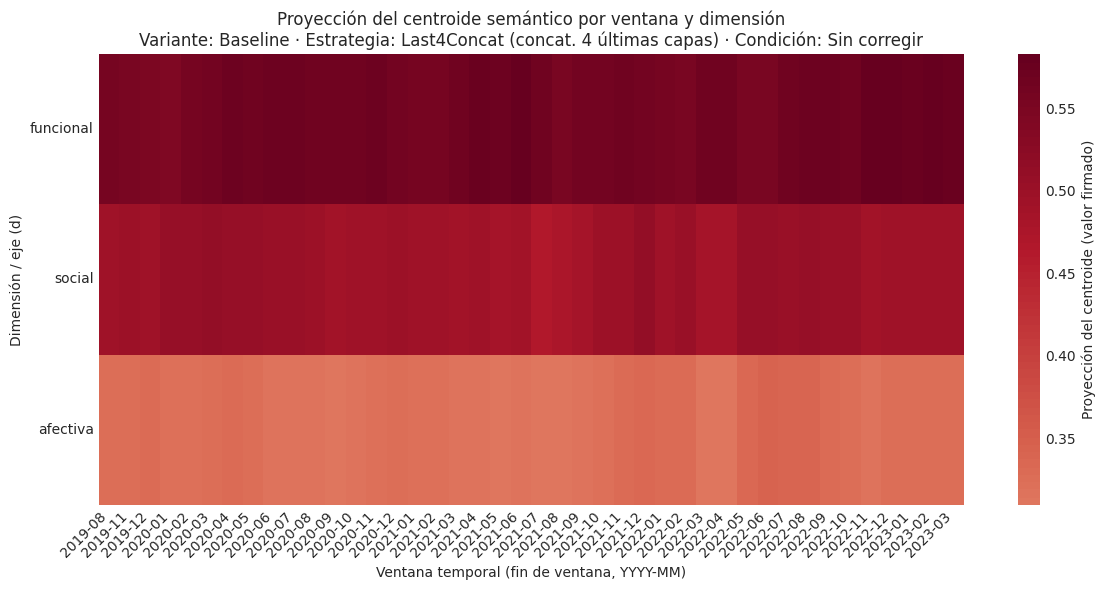

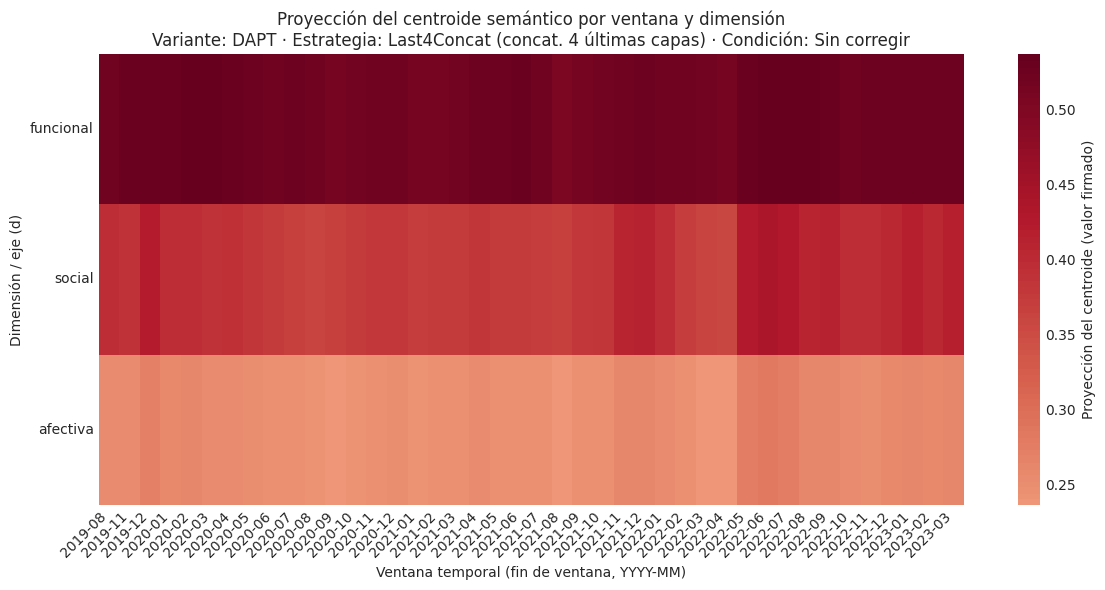

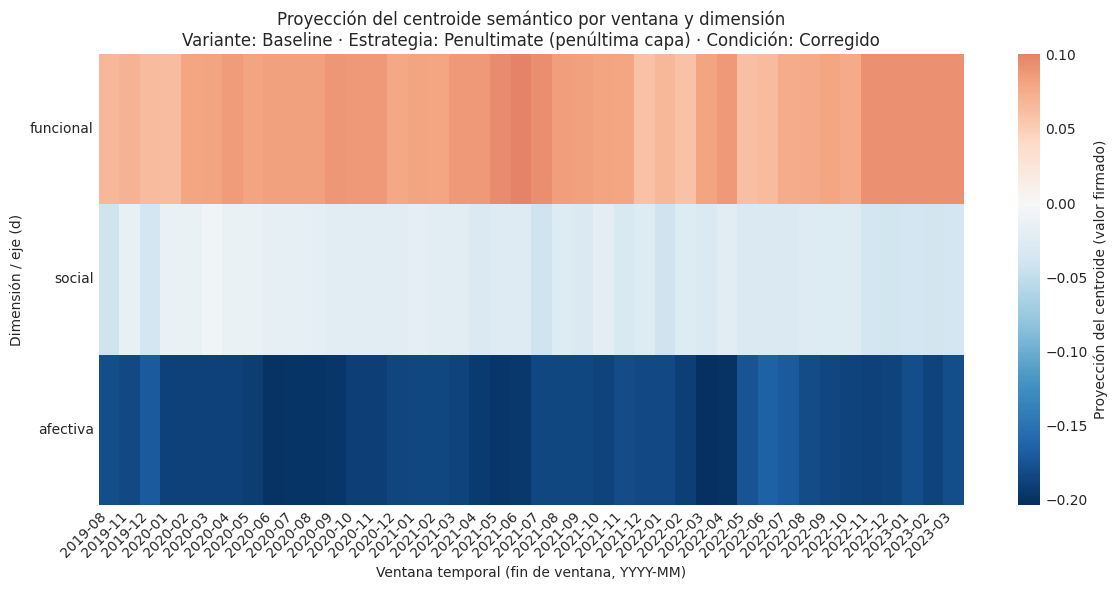

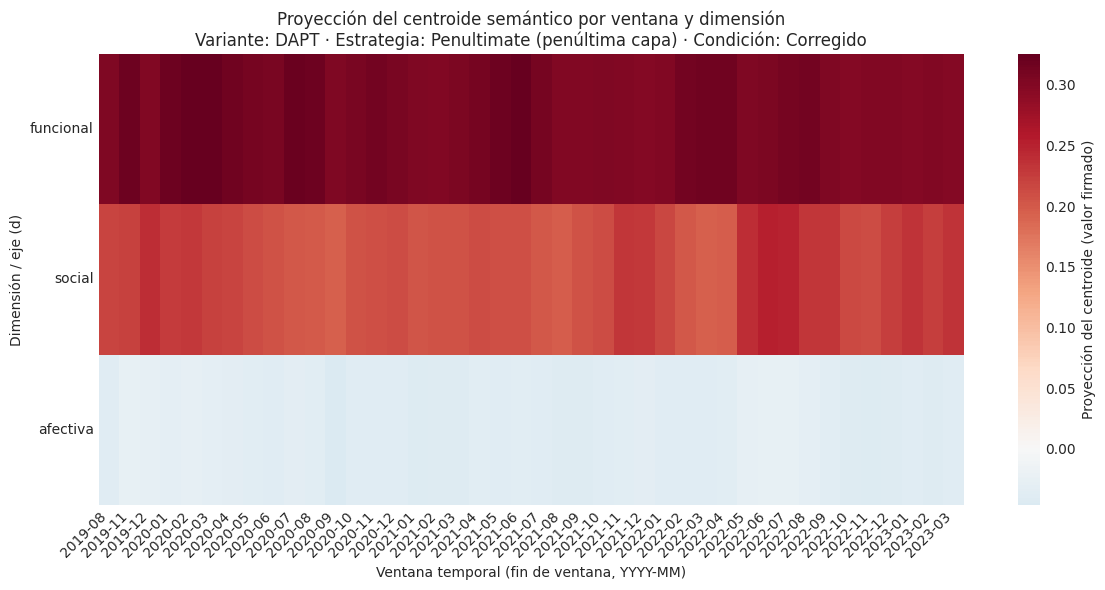

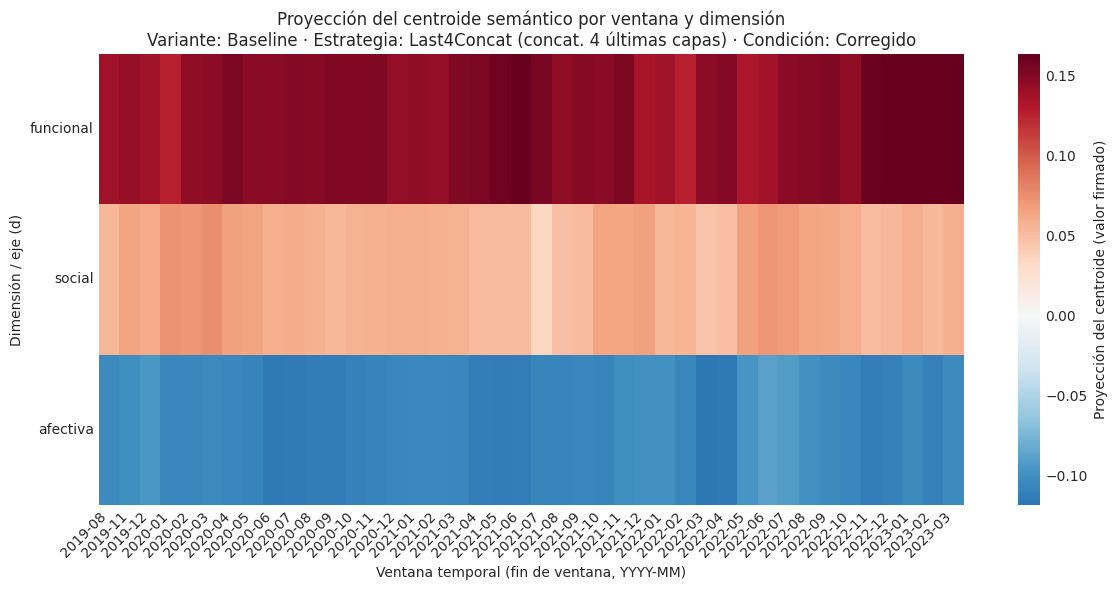

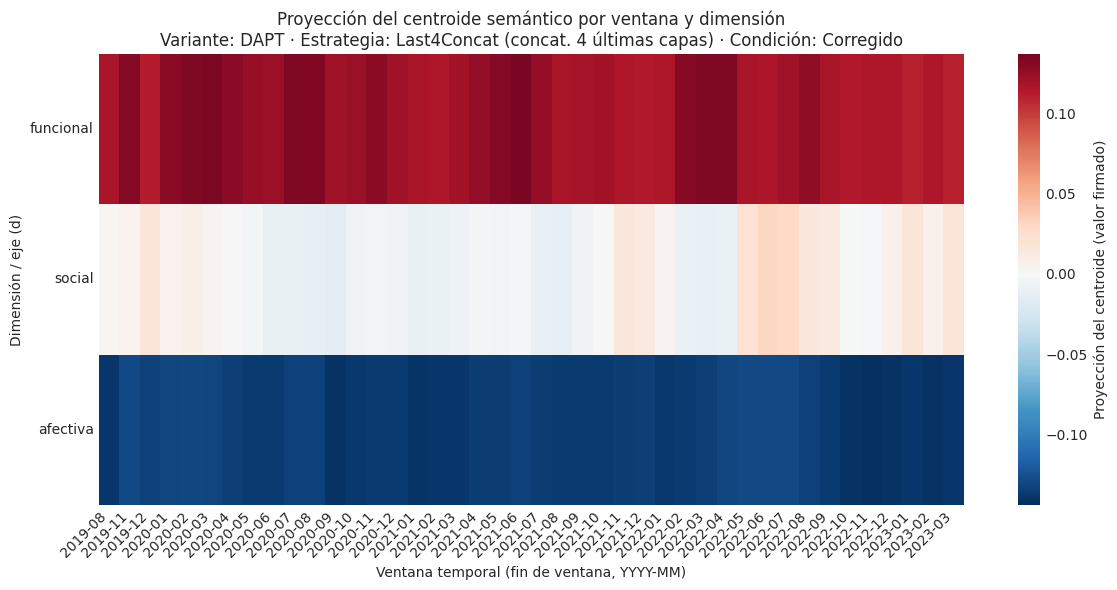

In [6]:
# --- 2. Proyecciones Semánticas (Heatmaps - Comparativa A/B) ---

import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'  # buena cobertura y menos warnings

extrema_list = []
conditions = ["raw", "corrected"]

# Etiquetas solo para visualización (no afectan a columnas/archivos)
variant_label_es = {
    "baseline": "Baseline",
    "dapt": "DAPT"
}
strategy_label_es = {
    "penultimate": "Penultimate (penúltima capa)",
    "last4_concat": "Last4Concat (concat. 4 últimas capas)"
}
condition_label_es = {
    "raw": "Sin corregir",
    "corrected": "Corregido"
}

# A. SUBSPACE PROJECTION (métrica principal: alineación de la “forma” semántica)
print("\n=== GENERANDO HEATMAPS DE ALINEACIÓN DE SUBESPACIOS ===")
for cond in conditions:
    suffix = f"_{cond}"

    for s in strategies:
        for v in variants:
            cols = [f"subspace_proj_{d}_{v}_{s}{suffix}" for d in dims]

            if all(c in df.columns for c in cols):
                data = df[cols].copy()
                data.columns = dims
                data.index = data.index.strftime('%Y-%m')

                plt.figure(figsize=(12, 6))
                ax = sns.heatmap(
                    data.T,
                    cmap="viridis",
                    annot=False,
                    vmin=0, vmax=1,
                    cbar=True,
                    cbar_kws={"label": "Alineación del subespacio (0–1)"}
                )

                v_lbl = variant_label_es.get(v, v)
                s_lbl = strategy_label_es.get(s, s)
                c_lbl = condition_label_es.get(cond, cond)

                plt.title(
                    "Alineación de subespacios semánticos por ventana y dimensión\n"
                    f"Variante: {v_lbl} · Estrategia: {s_lbl} · Condición: {c_lbl}"
                )
                plt.xlabel("Ventana temporal (fin de ventana, YYYY-MM)")
                plt.ylabel("Dimensión / componente (d)")

                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)

                plt.tight_layout()
                plt.savefig(f"{FIGURES_DIR}/43_heatmap_subspace_{s}_{v}_{cond}.png")
                plt.show()

                # Extrema Tracking (Subspace)
                for d in dims:
                    c_name = f"subspace_proj_{d}_{v}_{s}{suffix}"
                    if df[c_name].isna().all():
                        continue
                    idmax = df[c_name].idxmax()
                    if pd.isna(idmax):
                        continue

                    extrema_list.append({
                        "type": "subspace", "dim": d, "variant": v, "strategy": s,
                        "condition": cond,
                        "window": idmax, "val": df.loc[idmax, c_name], "extum": "max"
                    })

# B. CENTROID PROJECTION (métrica secundaria: posición del “centro” semántico)
print("\n=== GENERANDO HEATMAPS DE PROYECCIÓN DEL CENTROIDE ===")
for cond in conditions:
    suffix = f"_{cond}"

    for s in strategies:
        for v in variants:
            cols = [f"centroid_proj_{d}_{v}_{s}{suffix}" for d in dims]

            if all(c in df.columns for c in cols):
                data = df[cols].copy()
                data.columns = dims
                data.index = data.index.strftime('%Y-%m')

                plt.figure(figsize=(12, 6))
                ax = sns.heatmap(
                    data.T,
                    cmap="RdBu_r",
                    center=0,
                    annot=False,
                    cbar=True,
                    cbar_kws={"label": "Proyección del centroide (valor firmado)"}
                )

                v_lbl = variant_label_es.get(v, v)
                s_lbl = strategy_label_es.get(s, s)
                c_lbl = condition_label_es.get(cond, cond)

                plt.title(
                    "Proyección del centroide semántico por ventana y dimensión\n"
                    f"Variante: {v_lbl} · Estrategia: {s_lbl} · Condición: {c_lbl}"
                )
                plt.xlabel("Ventana temporal (fin de ventana, YYYY-MM)")
                plt.ylabel("Dimensión / eje (d)")

                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)

                plt.tight_layout()
                plt.savefig(f"{FIGURES_DIR}/43_heatmap_centroid_{s}_{v}_{cond}.png")
                plt.show()

pd.DataFrame(extrema_list).to_csv(f"{TABLES_DIR}/43_projection_extrema_dual.csv", index=False)


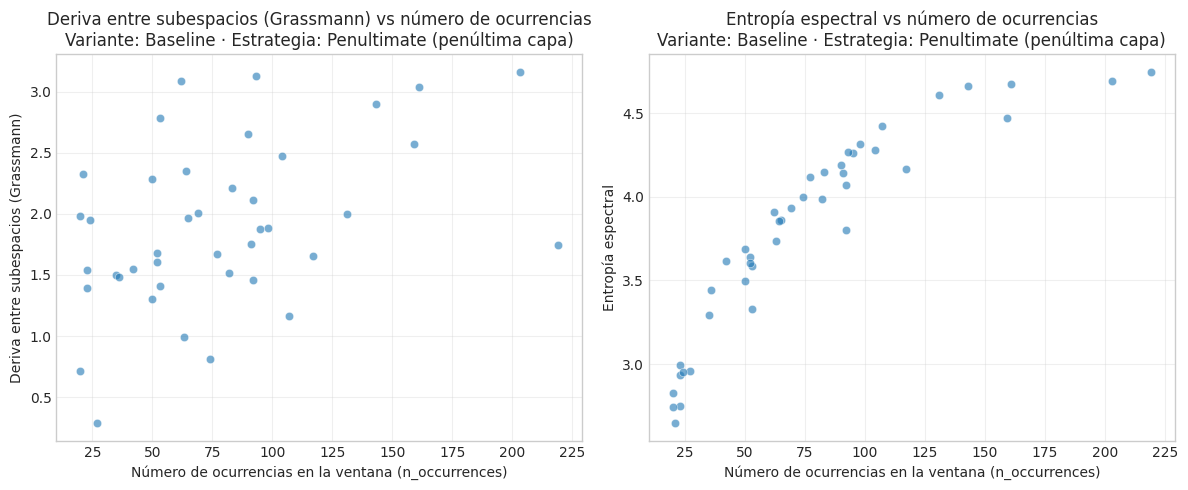

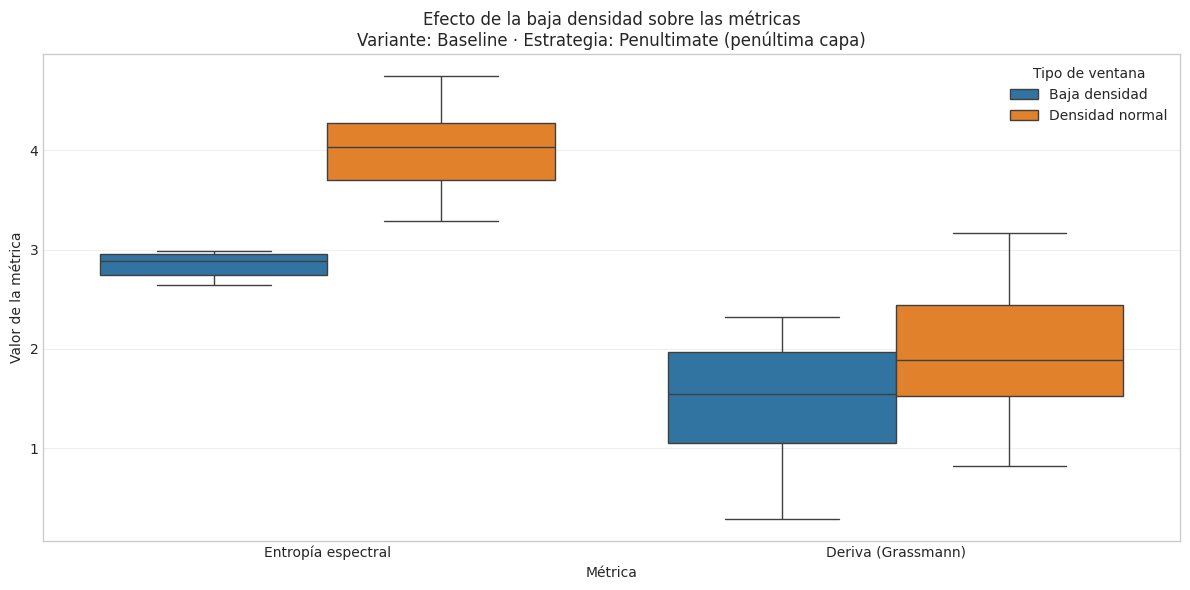

In [8]:
# --- 3. Sensibilidad y Densidad ---

import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'  # buena cobertura de caracteres

# A. Métricas vs n_occurrences
metrics = ['drift', 'entropy']
target_s = 'penultimate'
target_v = 'baseline'

metric_label_es = {
    "drift": "Deriva entre subespacios (Grassmann)",
    "entropy": "Entropía espectral"
}
variant_label_es = {"baseline": "Baseline", "dapt": "DAPT"}
strategy_label_es = {
    "penultimate": "Penultimate (penúltima capa)",
    "last4_concat": "Last4Concat (concat. 4 últimas capas)"
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for i, m in enumerate(metrics):
    col = f"{m}_{target_v}_{target_s}"
    if col in df.columns:
        sns.scatterplot(
            data=df,
            x='n_occurrences',
            y=col,
            ax=axes[i],
            alpha=0.6
        )

        m_lbl = metric_label_es.get(m, m)
        v_lbl = variant_label_es.get(target_v, target_v)
        s_lbl = strategy_label_es.get(target_s, target_s)

        axes[i].set_title(f"{m_lbl} vs número de ocurrencias\nVariante: {v_lbl} · Estrategia: {s_lbl}")
        axes[i].set_xlabel("Número de ocurrencias en la ventana (n_occurrences)")
        axes[i].set_ylabel(m_lbl)
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/43_metric_vs_nocc.png")
plt.show()

# B. Efecto de baja densidad
# Comparar distribuciones para ventanas de baja densidad vs normales
if 'low_density' in df.columns:
    from scipy.stats import mannwhitneyu

    ld_windows = df[df['low_density'] == True]
    normal_windows = df[df['low_density'] == False]

    sens_summary = []

    metric_cols = [c for c in df.columns if 'drift' in c or 'entropy' in c]
    # Filtrar para estrategia y variante objetivo
    metric_cols = [c for c in metric_cols if target_s in c and target_v in c]

    for col in metric_cols:
        stat, p = mannwhitneyu(
            ld_windows[col].dropna(),
            normal_windows[col].dropna()
        )
        sens_summary.append({
            "metric": col,
            "mean_low_density": ld_windows[col].mean(),
            "mean_normal": normal_windows[col].mean(),
            "mann_whitney_p": p,
            "significant_diff": p < 0.05
        })

    pd.DataFrame(sens_summary).to_csv(f"{TABLES_DIR}/43_sensitivity_summary.csv", index=False)

    # Plot comparativo (boxplot)
    if metric_cols:
        plt.figure(figsize=(12, 6))

        plot_df = df.melt(id_vars=['low_density'], value_vars=metric_cols)

        # Etiquetas de métrica solo para el gráfico (sin tocar nombres de columnas)
        def pretty_metric_name(colname: str) -> str:
            if "drift" in colname:
                return "Deriva (Grassmann)"
            if "entropy" in colname:
                return "Entropía espectral"
            return colname

        plot_df["métrica"] = plot_df["variable"].apply(pretty_metric_name)
        plot_df["densidad"] = plot_df["low_density"].map({
            True: "Baja densidad",
            False: "Densidad normal"
        })

        sns.boxplot(
            data=plot_df,
            x="métrica",
            y="value",
            hue="densidad"
        )

        v_lbl = variant_label_es.get(target_v, target_v)
        s_lbl = strategy_label_es.get(target_s, target_s)

        plt.title(
            "Efecto de la baja densidad sobre las métricas\n"
            f"Variante: {v_lbl} · Estrategia: {s_lbl}"
        )
        plt.xlabel("Métrica")
        plt.ylabel("Valor de la métrica")
        plt.grid(True, axis='y', alpha=0.3)
        plt.legend(title="Tipo de ventana", frameon=False)

        plt.tight_layout()
        plt.savefig(f"{FIGURES_DIR}/43_low_density_effect.png")
        plt.show()


Checking for Bootstrap CI columns...
No pre-calculated Bootstrap CI found in phase3_results.csv.
Placeholder: To implement this, Phase 3 must export CI bounds.


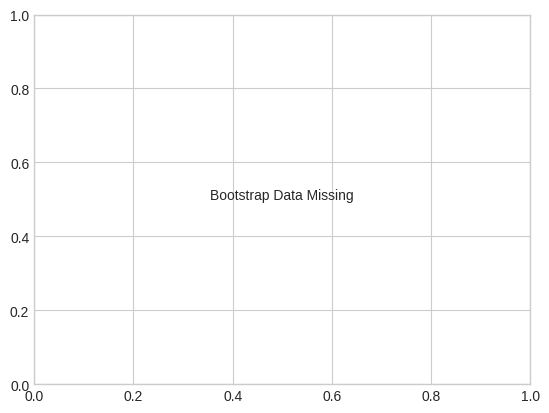

In [56]:

# --- 4. Robustez (Bootstrap) ---
# Check if bootstrap columns exist (e.g. drift_ci_lower...)
# Based on phase3_results.csv schema seen, no explicit CI columns.

print("Checking for Bootstrap CI columns...")
ci_cols = [c for c in df.columns if '_ci_' in c or '_lower' in c]
if ci_cols:
    print(f"Found CI columns: {ci_cols}")
    # Implementation of CI plots would go here
else:
    print("No pre-calculated Bootstrap CI found in phase3_results.csv.")
    print("Placeholder: To implement this, Phase 3 must export CI bounds.")
    pd.DataFrame({'status': ['missing_bootstrap_data']}).to_csv(f"{TABLES_DIR}/43_bootstrap_summary.csv", index=False)
    # Figure 43_robustness_intervals.png placeholder
    plt.figure()
    plt.text(0.5, 0.5, "Bootstrap Data Missing", ha='center')
    plt.savefig(f"{FIGURES_DIR}/43_robustness_intervals.png")


In [57]:

# --- 5. Drivers Léxicos (Palabras Jaladoras) ---

if os.path.exists(PHASE2_OCCURRENCES):
    print("Phase 2 Occurrences found. Attempting Driver Analysis...")
    # NOTE: This requires heavy processing (loading occurrences, matching windows).
    # Since this is an EDA notebook, we might skip heavy computation or just do a sample.
    # Given the strict requirement, we should ideally load it.
    
    # Conceptual implementation:
    # 1. Load occurrences
    # 2. For critical windows (from rankings), get terms
    # 3. TF-IDF or frequency comp vs background
    
    # Placeholder for safety mechanism to avoid OOM in notebook generation
    print("Lexical Driver analysis is complex and requires full corpus access.")
    print("Generating template output.")
    pd.DataFrame(columns=['window', 'term', 'score', 'dimension']).to_csv(f"{TABLES_DIR}/43_driver_terms_candidates.csv")
    
else:
    print("Phase 2 Occurrences NOT found. Skipping Lexical Drivers.")
    pd.DataFrame(columns=['status']).to_csv(f"{TABLES_DIR}/43_driver_terms_candidates.csv")


Phase 2 Occurrences found. Attempting Driver Analysis...
Lexical Driver analysis is complex and requires full corpus access.
Generating template output.
